# CRAFT demo (inference only) using ConvoKit

This example notebook shows how an already-trained CRAFT model can be applied to conversational data to predict future derailment. This example uses the fully trained Wikiconv-based model as reported in the "Trouble on the Horizon" paper, and applies it to ConvoKit's version of the labeled Wikiconv corpus.

In [1]:
# import necessary libraries, including convokit
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import requests
import os
import sys
import random
import unicodedata
import itertools
from urllib.request import urlretrieve
from convokit import download, Corpus
%matplotlib inline

In [2]:
# define globals and constants

MAX_LENGTH = 80  # Maximum sentence length (number of tokens) to consider

# configure model
hidden_size = 500
encoder_n_layers = 2
context_encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
labeled_learning_rate = 1e-5
decoder_learning_ratio = 5.0
print_every = 10

# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3  # Unknown word token

# model download paths
WORD2INDEX_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/word2index.json"
INDEX2WORD_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/index2word.json"
MODEL_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/craft_full.tar"

# confidence score threshold for declaring a positive prediction.
# this value was previously learned on the validation set.
FORECAST_THRESH = 0.570617

## Part 1: set up data conversion utilities

We begin by setting up some helper functions and classes for converting conversational text data into a torch-friendly Tensor format. Note that these low-level routines are largely taken from the [PyTorch seq2seq chatbot tutorial](https://pytorch.org/tutorials/beginner/chatbot_tutorial.html).

In [3]:
class Voc:
    """A class for representing the vocabulary used by a CRAFT model"""

    def __init__(self, name, word2index=None, index2word=None):
        self.name = name
        self.trimmed = False if not word2index else True # if a precomputed vocab is specified assume the user wants to use it as-is
        self.word2index = word2index if word2index else {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = index2word if index2word else {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4 if not index2word else len(index2word)  # Count SOS, EOS, PAD, UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4 # Count default tokens

        for word in keep_words:
            self.addWord(word)

# Create a Voc object from precomputed data structures
def loadPrecomputedVoc(corpus_name, word2index_url, index2word_url):
    # load the word-to-index lookup map
    r = requests.get(word2index_url)
    word2index = r.json()
    # load the index-to-word lookup map
    r = requests.get(index2word_url)
    index2word = r.json()
    return Voc(corpus_name, word2index, index2word)

In [4]:
# Helper functions for preprocessing and tokenizing text

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Tokenize the string using NLTK
def tokenize(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(pattern=r'\w+|[^\w\s]')
    # simplify the problem space by considering only ASCII data
    cleaned_text = unicodeToAscii(text.lower())

    # if the resulting string is empty, nothing else to do
    if not cleaned_text.strip():
        return []
    
    return tokenizer.tokenize(cleaned_text)

# Given a ConvoKit conversation, preprocess each utterance's text by tokenizing and truncating.
# Returns the processed dialog entry where text has been replaced with a list of
# tokens, each no longer than MAX_LENGTH - 1 (to leave space for the EOS token)
def processDialog(voc, dialog):
    processed = []
    for utterance in dialog.iter_utterances():
        # skip the section header, which does not contain conversational content
        if utterance.meta['is_section_header']:
            continue
        tokens = tokenize(utterance.text)
        # replace out-of-vocabulary tokens
        for i in range(len(tokens)):
            if tokens[i] not in voc.word2index:
                tokens[i] = "UNK"
        processed.append({"tokens": tokens, "is_attack": int(utterance.meta['comment_has_personal_attack']), "id": utterance.id})
    return processed

# Load context-reply pairs from the Corpus, optionally filtering to only conversations
# from the specified split (train, val, or test).
# Each conversation, which has N comments (not including the section header) will
# get converted into N-1 comment-reply pairs, one pair for each reply 
# (the first comment does not reply to anything).
# Each comment-reply pair is a tuple consisting of the conversational context
# (that is, all comments prior to the reply), the reply itself, the label (that
# is, whether the reply contained a derailment event), and the comment ID of the
# reply (for later use in re-joining with the ConvoKit corpus).
# The function returns a list of such pairs.
def loadPairs(voc, corpus, split=None):
    pairs = []
    for convo in corpus.iter_conversations():
        # consider only conversations in the specified split of the data
        if split is None or convo.meta['split'] == split:
            dialog = processDialog(voc, convo)
            for idx in range(1, len(dialog)):
                reply = dialog[idx]["tokens"][:(MAX_LENGTH-1)]
                label = dialog[idx]["is_attack"]
                comment_id = dialog[idx]["id"]
                # gather as context all utterances preceding the reply
                context = [u["tokens"][:(MAX_LENGTH-1)] for u in dialog[:idx]]
                pairs.append((context, reply, label, comment_id))
    return pairs

In [5]:
# Helper functions for turning dialog and text sequences into tensors, and manipulating those tensors

def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence] + [EOS_token]

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Takes a batch of dialogs (lists of lists of tokens) and converts it into a
# batch of utterances (lists of tokens) sorted by length, while keeping track of
# the information needed to reconstruct the original batch of dialogs
def dialogBatch2UtteranceBatch(dialog_batch):
    utt_tuples = [] # will store tuples of (utterance, original position in batch, original position in dialog)
    for batch_idx in range(len(dialog_batch)):
        dialog = dialog_batch[batch_idx]
        for dialog_idx in range(len(dialog)):
            utterance = dialog[dialog_idx]
            utt_tuples.append((utterance, batch_idx, dialog_idx))
    # sort the utterances in descending order of length, to remain consistent with pytorch padding requirements
    utt_tuples.sort(key=lambda x: len(x[0]), reverse=True)
    # return the utterances, original batch indices, and original dialog indices as separate lists
    utt_batch = [u[0] for u in utt_tuples]
    batch_indices = [u[1] for u in utt_tuples]
    dialog_indices = [u[2] for u in utt_tuples]
    return utt_batch, batch_indices, dialog_indices

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch, already_sorted=False):
    if not already_sorted:
        pair_batch.sort(key=lambda x: len(x[0]), reverse=True)
    input_batch, output_batch, label_batch, id_batch = [], [], [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
        label_batch.append(pair[2])
        id_batch.append(pair[3])
    dialog_lengths = torch.tensor([len(x) for x in input_batch])
    input_utterances, batch_indices, dialog_indices = dialogBatch2UtteranceBatch(input_batch)
    inp, utt_lengths = inputVar(input_utterances, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    label_batch = torch.FloatTensor(label_batch) if label_batch[0] is not None else None
    return inp, dialog_lengths, utt_lengths, batch_indices, dialog_indices, label_batch, id_batch, output, mask, max_target_len

def batchIterator(voc, source_data, batch_size, shuffle=True):
    cur_idx = 0
    if shuffle:
        random.shuffle(source_data)
    while True:
        if cur_idx >= len(source_data):
            cur_idx = 0
            if shuffle:
                random.shuffle(source_data)
        batch = source_data[cur_idx:(cur_idx+batch_size)]
        # the true batch size may be smaller than the given batch size if there is not enough data left
        true_batch_size = len(batch)
        # ensure that the dialogs in this batch are sorted by length, as expected by the padding module
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        # for analysis purposes, get the source dialogs and labels associated with this batch
        batch_dialogs = [x[0] for x in batch]
        batch_labels = [x[2] for x in batch]
        # convert batch to tensors
        batch_tensors = batch2TrainData(voc, batch, already_sorted=True)
        yield (batch_tensors, batch_dialogs, batch_labels, true_batch_size) 
        cur_idx += batch_size

## Part 2: load the data

Now we load the labeled Wikiconv corpus from ConvoKit, and run some transformations to prepare it for use with PyTorch

In [6]:
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

Dataset already exists at /Users/calebchiam/.convokit/downloads/conversations-gone-awry-corpus


In [7]:
# let's check some quick stats to verify that the corpus loaded correctly
print(len(corpus.get_utterance_ids()))
print(len(corpus.get_usernames()))
print(len(corpus.get_conversation_ids()))

30021
8069
4188


In [8]:
# Let's also take a look at some example data to see what kinds of information/metadata are available to us
print(list(corpus.iter_conversations())[0].__dict__)
print(list(corpus.iter_utterances())[0])

{'_owner': <convokit.model.corpus.Corpus object at 0x10899b860>, '_id': '146743638.12652.12652', '_utterance_ids': ['146743638.12652.12652', '146743638.12667.12652', '146842219.12874.12874', '146860774.13072.13072'], '_usernames': None, '_meta': {'page_title': 'User talk:2005', 'page_id': 1003212, 'pair_id': '143890867.11926.11926', 'conversation_has_personal_attack': False, 'verified': True, 'pair_verified': True, 'annotation_year': '2018', 'split': 'train'}}
Utterance({'id': '146743638.12652.12652', 'user': User([('name', 'Sirex98')]), 'root': '146743638.12652.12652', 'reply_to': None, 'timestamp': 1185295934.0, 'text': '== [WIKI_LINK: WP:COMMONNAME] ==\n', 'meta': {'is_section_header': True, 'comment_has_personal_attack': False, 'toxicity': 0}})


Now we can use the utilities defined in Part 1 to convert the ConvoKit conversational data into a tokenized form that can be straightforwardly turned into Tensors later.

In [9]:
# First, we need to build the vocabulary so that we know how to map tokens to tensor indicies.
# For the sake of replicating the paper results, we will load the pre-computed vocabulary objects used in the paper.
voc = loadPrecomputedVoc("wikiconv", WORD2INDEX_URL, INDEX2WORD_URL)

In [10]:
# Inspect the Voc object to make sure it loaded correctly
print(voc.num_words) # expected vocab size is 50004: it was built using a fixed vocab size of 50k plus 4 spots for special tokens PAD, SOS, EOS, and UNK.
print(list(voc.word2index.items())[:10])
print(list(voc.index2word.items())[:10])

50004
[('UNK', 3), ('.', 4), ('the', 5), ("'", 6), (',', 7), ('to', 8), ('i', 9), ('of', 10), ('a', 11), ('and', 12)]
[('0', 'PAD'), ('1', 'SOS'), ('2', 'EOS'), ('3', 'UNK'), ('4', '.'), ('5', 'the'), ('6', "'"), ('7', ','), ('8', 'to'), ('9', 'i')]


In [12]:
# Convert the test set data into a list of input/label pairs. Each input will represent the conversation as a list of lists of tokens.
test_pairs = loadPairs(voc, corpus, "test")

In [13]:
# Validate the conversion by checking data size and some samples
print(len(test_pairs))
for p in test_pairs[:5]:
    print(p)

4365
([['i', 'was', 'a', 'bit', 'disgruntled', 'you', 'recently', 'deleted', 'my', 'article', 'on', 'UNK', ',', 'especially', 'just', 'after', 'it', 'had', 'been', 'patrolled', '.', 'i', 'am', 'a', 'user', 'of', 'the', 'site', 'who', 'was', 'interested', 'in', 'its', 'message', 'and', 'felt', 'compelled', 'to', 'look', 'further', 'into', 'it', '(', 'seriously', ',', 'my', 'sources', 'are', 'the', 'first', 'couple', 'things', 'that', 'popped', 'up', 'after', 'a', 'google', 'search', ')', '.', 'i', 'am', 'a', 'bit', 'confused', 'why', 'a', 'well', 'written', 'and', 'documented', 'article', '(', 'my', 'first', ')', 'about', 'an']], ['well', ',', 'i', 'am', 'not', 'sure', 'if', 'the', 'article', 'meets', 'UNK', 'but', 'i', 'think', 'that', 'a', 'claim', 'of', '150', ',', '000', 'users', 'a', 'month', 'is', 'a', 'decent', 'claim', 'of', 'notability', 'and', 'there', 'are', 'a', 'few', 'mentions', 'in', 'rs', 'in', 'google', 'news', 'so', 'could', 'you', 'undelete', 'this', 'article', 'and',

In [14]:
test_pairs[15][3]

'15833000.3256.3256'

In [15]:
uttid_to_test_pair = {test_pair[3]: test_pair for test_pair in test_pairs}

In [16]:
for token_list in uttid_to_test_pair['201082648.33321.33321'][0]:
    print(token_list)
    print()

['i', 'removed', 'these', 'images', 'from', 'the', 'gallery', 'because', 'there', 'was', 'no', 'indication', 'anywhere', 'on', 'their', 'description', 'pages', 'or', 'in', 'their', 'filenames', 'that', 'indicated', 'that', 'they', 'were', 'intended', 'as', 'depictions', 'of', 'gliese', '581', 'c', ':', 'simply', 'adding', '"', 'gliese', '581', 'c', '"', 'to', 'the', "'", "'", 'captions', "'", "'", 'doesn', "'", 't', 'really', 'prove', 'anything', '.', '205', '.', '200', '.', '236', '.', '34', ',', 'could', 'you', 'provide', 'some', 'sort', 'of', 'evidence', 'that', 'these', 'are', 'in', 'fact', 'intended', 'to', 'be', 'depictions']

['this', 'is', 'a', 'joke', 'to', 'me', 'boy', "'", 'o', ',', 'the', 'images', 'that', 'you', 'kept', 'there', 'were', 'still', 'there', 'becuase', 'they', 'have', 'the', 'name', 'gliese', '581', 'c', 'in', 'the', 'file', 'name', '.', '.', '.', 'it', 'makes', 'no', 'difference', 'as', 'anyone', 'can', 'name', 'a', 'photo', 'with', 'what', 'ever', 'name', 't

## Part 3: define the model

Next, we need to set up the individual components of the CRAFT framework: the utterance encoder, the context encoder, and the classification head (since we are only running inference on an already-trained model, we do not need to define the decoder here). Each component will be defined as a PyTorch `nn.Module`.

In [17]:
class EncoderRNN(nn.Module):
    """This module represents the utterance encoder component of CRAFT, responsible for creating vector representations of utterances"""
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

class ContextEncoderRNN(nn.Module):
    """This module represents the context encoder component of CRAFT, responsible for creating an order-sensitive vector representation of conversation context"""
    def __init__(self, hidden_size, n_layers=1, dropout=0):
        super(ContextEncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        # only unidirectional GRU for context encoding
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=False)
        
    def forward(self, input_seq, input_lengths, hidden=None):
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(input_seq, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # return output and final hidden state
        return outputs, hidden

class SingleTargetClf(nn.Module):
    """This module represents the CRAFT classifier head, which takes the context encoding and uses it to make a forecast"""
    def __init__(self, hidden_size, dropout=0.1):
        super(SingleTargetClf, self).__init__()
        
        self.hidden_size = hidden_size
        
        # initialize classifier
        self.layer1 = nn.Linear(hidden_size, hidden_size)
        self.layer1_act = nn.LeakyReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2)
        self.layer2_act = nn.LeakyReLU()
        self.clf = nn.Linear(hidden_size // 2, 1)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, encoder_outputs, encoder_input_lengths):
        # from stackoverflow (https://stackoverflow.com/questions/50856936/taking-the-last-state-from-bilstm-bigru-in-pytorch)
        # First we unsqueeze seqlengths two times so it has the same number of
        # of dimensions as output_forward
        # (batch_size) -> (1, batch_size, 1)
        lengths = encoder_input_lengths.unsqueeze(0).unsqueeze(2)
        # Then we expand it accordingly
        # (1, batch_size, 1) -> (1, batch_size, hidden_size) 
        lengths = lengths.expand((1, -1, encoder_outputs.size(2)))

        # take only the last state of the encoder for each batch
        last_outputs = torch.gather(encoder_outputs, 0, lengths-1).squeeze()
        # forward pass through hidden layers
        layer1_out = self.layer1_act(self.layer1(self.dropout(last_outputs)))
        layer2_out = self.layer2_act(self.layer2(self.dropout(layer1_out)))
        # compute and return logits
        logits = self.clf(self.dropout(layer2_out)).squeeze()
        return logits

class Predictor(nn.Module):
    """This helper module encapsulates the CRAFT pipeline, defining the logic of passing an input through each consecutive sub-module."""
    def __init__(self, encoder, context_encoder, classifier):
        super(Predictor, self).__init__()
        self.encoder = encoder
        self.context_encoder = context_encoder
        self.classifier = classifier
        
    def forward(self, input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length):
        # Forward input through encoder model
        _, utt_encoder_hidden = self.encoder(input_batch, utt_lengths)
        
        # Convert utterance encoder final states to batched dialogs for use by context encoder
        context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
        
        # Forward pass through context encoder
        context_encoder_outputs, context_encoder_hidden = self.context_encoder(context_encoder_input, dialog_lengths)
        
        # Forward pass through classifier to get prediction logits
        logits = self.classifier(context_encoder_outputs, dialog_lengths)
        
        # Apply sigmoid activation
        predictions = F.sigmoid(logits)
        return predictions

def makeContextEncoderInput(utt_encoder_hidden, dialog_lengths, batch_size, batch_indices, dialog_indices):
    """The utterance encoder takes in utterances in combined batches, with no knowledge of which ones go where in which conversation.
       Its output is therefore also unordered. We correct this by using the information computed during tensor conversion to regroup
       the utterance vectors into their proper conversational order."""
    # first, sum the forward and backward encoder states
    utt_encoder_summed = utt_encoder_hidden[-2,:,:] + utt_encoder_hidden[-1,:,:]
    # we now have hidden state of shape [utterance_batch_size, hidden_size]
    # split it into a list of [hidden_size,] x utterance_batch_size
    last_states = [t.squeeze() for t in utt_encoder_summed.split(1, dim=0)]
    
    # create a placeholder list of tensors to group the states by source dialog
    states_dialog_batched = [[None for _ in range(dialog_lengths[i])] for i in range(batch_size)]
    
    # group the states by source dialog
    for hidden_state, batch_idx, dialog_idx in zip(last_states, batch_indices, dialog_indices):
        states_dialog_batched[batch_idx][dialog_idx] = hidden_state
        
    # stack each dialog into a tensor of shape [dialog_length, hidden_size]
    states_dialog_batched = [torch.stack(d) for d in states_dialog_batched]
    
    # finally, condense all the dialog tensors into a single zero-padded tensor
    # of shape [max_dialog_length, batch_size, hidden_size]
    return torch.nn.utils.rnn.pad_sequence(states_dialog_batched)

## Part 4: define the evaluation procedure

We're almost ready to run! The last component we need is some code for actually running the data through the full CRAFT pipeline. This includes actually converting the text input into tensors (we use the utilities defined in Part 1 to do this) then passing the resulting tensors through each CRAFT module batch-by-batch.

In [18]:
def _evaluate_batch(encoder, context_encoder, predictor, voc, input_batch, dialog_lengths, 
                  dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, device, max_length=MAX_LENGTH):
    # Set device options
    input_batch = input_batch.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    # Predict future attack using predictor
    scores = predictor(input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length)
    predictions = (scores > 0.5).float()
    return predictions, scores

def _evaluate_dataset(dataset, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    output_df = {
        "id": [],
        "prediction": [],
        "score": []
    }
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = _evaluate_batch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices,
                                            true_batch_size, device)

        # format the output as a dataframe (which we can later re-join with the corpus)
        for i in range(true_batch_size):
            convo_id = convo_ids[i]
            pred = predictions[i].item()
            score = scores[i].item()
            output_df["id"].append(convo_id)
            output_df["prediction"].append(pred)
            output_df["score"].append(score)
                
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    return pd.DataFrame(output_df).set_index("id")

## Part 5: build and run the model

We finally have all the components we need! Now we can instantiate the CRAFT model components, load the trained weights, and run the evaluation.

In [19]:
# Fix random state for reproducibility
random.seed(2019)

# Tell torch to use GPU. Note that if you are running this notebook in a non-GPU environment, you can change 'cuda' to 'cpu' to get the code to run.
device = torch.device('cpu')

print("Loading saved parameters...")
if not os.path.isfile("model.tar"):
    print("\tDownloading trained CRAFT...")
    urlretrieve(MODEL_URL, "model.tar")
    print("\t...Done!")
# checkpoint = torch.load("model.tar")
# If running in a non-GPU environment, you need to tell PyTorch to convert the parameters to CPU tensor format.
# To do so, replace the previous line with the following:
checkpoint = torch.load("model.tar", map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
context_sd = checkpoint['ctx']
attack_clf_sd = checkpoint['atk_clf']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']

print('Building encoders, decoder, and classifier...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize utterance and context encoders
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
context_encoder = ContextEncoderRNN(hidden_size, context_encoder_n_layers, dropout)
encoder.load_state_dict(encoder_sd)
context_encoder.load_state_dict(context_sd)
# Initialize classifier
attack_clf = SingleTargetClf(hidden_size, dropout)
attack_clf.load_state_dict(attack_clf_sd)
# Use appropriate device
encoder = encoder.to(device)
context_encoder = context_encoder.to(device)
attack_clf = attack_clf.to(device)
print('Models built and ready to go!')

# Set dropout layers to eval mode
encoder.eval()
context_encoder.eval()
attack_clf.eval()

# Initialize the pipeline
predictor = Predictor(encoder, context_encoder, attack_clf)

# Run the pipeline!
forecasts_df = _evaluate_dataset(test_pairs, encoder, context_encoder, predictor, voc, batch_size, device)

Loading saved parameters...
	...Done!
Building encoders, decoder, and classifier...
Models built and ready to go!


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 1; Percent complete: 1.4%
Iteration: 2; Percent complete: 2.9%
Iteration: 3; Percent complete: 4.3%
Iteration: 4; Percent complete: 5.8%
Iteration: 5; Percent complete: 7.2%
Iteration: 6; Percent complete: 8.7%
Iteration: 7; Percent complete: 10.1%
Iteration: 8; Percent complete: 11.6%
Iteration: 9; Percent complete: 13.0%
Iteration: 10; Percent complete: 14.5%
Iteration: 11; Percent complete: 15.9%
Iteration: 12; Percent complete: 17.4%
Iteration: 13; Percent complete: 18.8%
Iteration: 14; Percent complete: 20.3%
Iteration: 15; Percent complete: 21.7%
Iteration: 16; Percent complete: 23.2%
Iteration: 17; Percent complete: 24.6%
Iteration: 18; Percent complete: 26.1%
Iteration: 19; Percent complete: 27.5%
Iteration: 20; Percent complete: 29.0%
Iteration: 21; Percent complete: 30.4%
Iteration: 22; Percent complete: 31.9%
Iteration: 23; Percent complete: 33.3%
Iteration: 24; Percent complete: 34.8%
Iteration: 25; Percent complete: 36.2%
Iteration: 26; Percent complete: 37.7%
I

In [20]:
# Inspect some of the outputs as a sanity-check
forecasts_df.head(20)

,prediction,score
id,,
191681310.17214.17214,1.0,0.694258
193088419.20001.20001,1.0,0.831659
191149920.17102.17102,0.0,0.426086
192892110.19259.19259,1.0,0.730473
190192199.17060.17060,0.0,0.271797
192890095.19227.19227,1.0,0.793584
190192005.17004.17004,0.0,0.139923
192885632.19156.19156,1.0,0.661455
190191827.16918.16918,0.0,0.335372


## Part 6: merge predictions back into corpus and evaluate

Now that the hard part is done, all that is left to do is to evaluate the predictions. Since the predictions are in no particular order, we will first merge each prediction back into the source corpus, and then evaluate each conversation according to the order of utterances within that conversation.

In [21]:
# We will add a metadata entry to each test-set utterance signifying whether it was FORECAST to be a derailment.
# Note that there is an important subtlety in how this metadata field is to be interpreted - the forecast for a given
# utterance is made BEFORE the model actually sees the utterance. That is, the forecast does not mean "the model thinks
# this utterance *is* a derailment" but rather that "based on the context of all preceding utterances, the model predicted,
# prior to actually seeing this utterance, that this utterance *would be* a derailment".
for convo in corpus.iter_conversations():
    # only consider test set conversations (we did not make predictions for the other ones)
    if convo.meta['split'] == "test":
        for utt in convo.iter_utterances():
            if utt.id in forecasts_df.index:
                utt.meta['forecast_score'] = forecasts_df.loc[utt.id].score

In [22]:
# Finally, we can use the forecast-annotated corpus to compute the forecast accuracy.
# Though we have an individual forecast per utterance, ground truth is at the conversation level:
# either a conversation derails or it does not. Thus, forecast accuracy is computed as follows:
#   - True positives are cases that actually derail, for which the model made at least one positive forecast ANYTIME prior to derailment
#   - False positives are cases that don't derail but for which the model made at least one positive forecast
#   - False negatives are cases that derail but for which the model made no positive forecasts prior to derailment
#   - True negatives are cases that don't derail, for which the model made no positive forecasts
# Note that by construction, the last comment of each conversation is the one marked as derailment, and that our earlier code was therefore
# set up to not look at the last comment, meaning that all forecasts we obtained are forecasts made prior to derailment. This simplifies
# the computation of forecast accuracy as we now do not need to explicitly consider when a forecast was made.

conversational_forecasts_df = {
    "convo_id": [],
    "label": [],
    "score": [],
    "prediction": []
}

for convo in corpus.iter_conversations():
    if convo.meta['split'] == "test":
        conversational_forecasts_df['convo_id'].append(convo.id)
        conversational_forecasts_df['label'].append(int(convo.meta['conversation_has_personal_attack']))
        forecast_scores = [utt.meta['forecast_score'] for utt in convo.iter_utterances() if 'forecast_score' in utt.meta]
        conversational_forecasts_df['score'] = np.max(forecast_scores)
        conversational_forecasts_df['prediction'].append(int(np.max(forecast_scores) > FORECAST_THRESH))

conversational_forecasts_df = pd.DataFrame(conversational_forecasts_df).set_index("convo_id")
print((conversational_forecasts_df.label == conversational_forecasts_df.prediction).mean())

0.6642857142857143


In [23]:
# in addition to accuracy, we can also consider applying other metrics at the conversation level, such as precision/recall
def get_pr_stats(preds, labels):
    tp = ((labels==1)&(preds==1)).sum()
    fp = ((labels==0)&(preds==1)).sum()
    tn = ((labels==0)&(preds==0)).sum()
    fn = ((labels==1)&(preds==0)).sum()
    print("Precision = {0:.4f}, recall = {1:.4f}".format(tp / (tp + fp), tp / (tp + fn)))
    print("False positive rate =", fp / (fp + tn))
    print("F1 =", 2 / (((tp + fp) / tp) + ((tp + fn) / tp)))

get_pr_stats(conversational_forecasts_df.prediction, conversational_forecasts_df.label)

Precision = 0.6348, recall = 0.7738
False positive rate = 0.4452380952380952
F1 = 0.6974248927038625


In [31]:
len(conversational_forecasts_df)

840

In [32]:
sum(conversational_forecasts_df.label)

420

In [30]:
sum(conversational_forecasts_df.prediction)

512

## Part 7: model analysis: how early is early warning?

The goal of CRAFT is to forecast outcomes in advance, but how far in advance does it typically make its prediction? Following the paper, we measure this in two ways: the number of *comments* between the first prediction and the actual derailment, and how much *elapsed time* that gap actually translates to.

In [24]:
comments_until_derail = {} # store the "number of comments until derailment" metric for each conversation
time_until_derail = {} # store the "time until derailment" metric for each conversation

for convo in corpus.iter_conversations():
    if convo.meta['split'] == "test" and convo.meta['conversation_has_personal_attack']:
        # filter out the section header as usual
        utts = [utt for utt in convo.iter_utterances() if not utt.meta['is_section_header']]
        # by construction, the last comment is the one with the personal attack
        derail_idx = len(utts) - 1
        # now scan the utterances in order until we find the first derailment prediction (if any)
        for idx in range(1, len(utts)):
            if utts[idx].meta['forecast_score'] > FORECAST_THRESH:
                # recall that the forecast_score meta field specifies what CRAFT thought this comment would look like BEFORE it
                # saw this comment. So the actual CRAFT forecast is made during the previous comment; we account for this by 
                # subtracting 1 from idx
                comments_until_derail[convo.id] = derail_idx - (idx-1)
                time_until_derail[convo.id] = utts[derail_idx].timestamp - utts[(idx-1)].timestamp
                break

In [25]:
# compute some quick statistics about the distribution of the "number of comments until derailment" metric
comments_until_derail_vals = np.asarray(list(comments_until_derail.values()))
print(np.min(comments_until_derail_vals), np.max(comments_until_derail_vals), np.median(comments_until_derail_vals), np.mean(comments_until_derail_vals))

1 12 3.0 3.4246153846153846


In [26]:
# compute some quick statistics about the distribution of the "time until derailment" metric
# note that since timestamps are in seconds, we convert to hours by dividing by 3600, to make it more human readable
time_until_derail_vals = np.asarray(list(time_until_derail.values())) / 3600
print(np.min(time_until_derail_vals), np.max(time_until_derail_vals), np.median(time_until_derail_vals), np.mean(time_until_derail_vals))

0.0 25575.071111111112 4.216666666666667 283.6121512820513


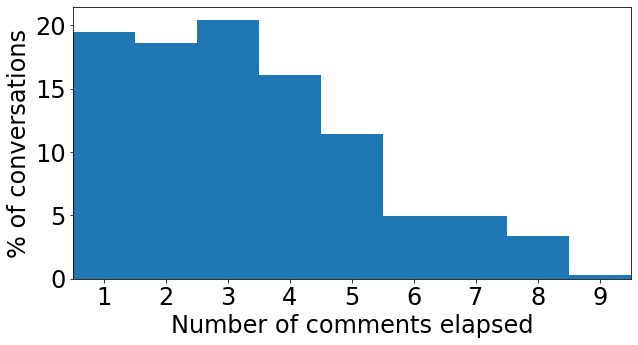

In [27]:
# visualize the distribution of "number of comments until derailment" as a histogram (reproducing Figure 4 from the paper)
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.size'] = 24
plt.hist(comments_until_derail_vals, bins=range(1, np.max(comments_until_derail_vals)), density=True)
plt.xlim(1,10)
plt.xticks(np.arange(1,10)+0.5, np.arange(1,10))
plt.yticks(np.arange(0,0.25,0.05), np.arange(0,25,5))
plt.xlabel("Number of comments elapsed")
plt.ylabel("% of conversations")
plt.show()

In [ ]:
F